Importação de bibliotecas

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from langchain_core.pydantic_v1 import BaseModel
from typing import Literal, Optional
from IPython.display import display, Image

/home/will/study/tc-fiap/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Modelos de LLM utilizados

In [2]:
# Modelos
llm_decisor = ChatOpenAI(model="gemma-3-1b-it", base_url="http://127.0.0.1:1234/v1", api_key="123", temperature=0.1)
llm_descricao = ChatOpenAI(model="qwen2.5-7b-describe@q4_k_m", base_url="http://127.0.0.1:1234/v1", api_key="123", temperature=0.5)
llm_qa = ChatOpenAI(model="llama3.2-3b-perguntas", base_url="http://127.0.0.1:1234/v1", api_key="123")

Definição do Estado do Graph

In [3]:
class Estado(BaseModel):
    mensagem: str
    acao: Optional[Literal['descrever', 'perguntar']] = None
    contexto: Optional[str] = None

Configuração dos nós do Grafo

In [4]:
# Nó decisor
def agente_decisor(state: Estado):
    prompt = ChatPromptTemplate.from_template(
        """
        Analise a mensagem do usuário abaixo:
        '{mensagem}'

        Se a mensagem for apenas o nome de um produto (ex.: "Mouse Gamer"), responda APENAS com 'descrever'.
        Se for uma pergunta (ex.: "O mouse gamer possui RGB?"), responda APENAS com 'perguntar'.
        """
    )
    chain = prompt | llm_decisor
    resposta = chain.invoke({"mensagem": state.mensagem}).content.lower().strip()
    return {"acao": resposta}

# Nó descrição
def agente_descricao(state: Estado):
    prompt = ChatPromptTemplate.from_template(
        """
        Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

        ### Instruction:
        Given a product title, generate a detailed and persuasive description highlighting its key features and benefits.

        ### Input:
        {produto}

        ### Response:

        """)
    chain = prompt | llm_descricao
    resposta = chain.invoke({"produto": state.mensagem}).content
    return {"contexto": resposta}

# Nó RAG para perguntas
def agente_pergunta(state: Estado):
    prompt = ChatPromptTemplate.from_template(
        """
        You are a chatbot that answers questions about products on a Market Store in Portuguese.

        You are a strict assistant that only responds based on the provided context.

        The context contains a title and a content of products on a Market Store.

        If the context is empty you MUST reply with:
        "I couldn't found any relevant information."

        If the context DOES NOT HAVE the product the user is looking for you MUST reply with:
        "Unfortunately we don't have this product."

        Context:
        {contexto}

        Pergunta:
        {pergunta}
        """
    )
    chain = prompt | llm_qa
    resposta = chain.invoke({"contexto": state.contexto, "pergunta": state.mensagem}).content

    return {"contexto": resposta}

Construção do grafo

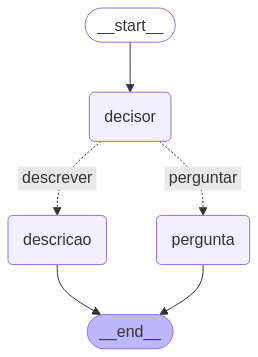

In [5]:
workflow = StateGraph(Estado)

workflow.add_node("decisor", agente_decisor)
workflow.add_node("descricao", agente_descricao)
workflow.add_node("pergunta", agente_pergunta)

# workflow.set_entry_point("decisor")
workflow.add_edge(START, "decisor")

workflow.add_conditional_edges(
    "decisor",
    lambda state: state.acao,
    {"descrever": "descricao", "perguntar": "pergunta"}
)

workflow.add_edge("descricao", END)
workflow.add_edge("pergunta", END)

# Compilação do grafo
app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

Simulações

In [7]:
app.invoke({"mensagem": "CISCO C100"})

{'mensagem': 'CISCO C100',
 'acao': 'descrever',
 'contexto': "The Cisco C100 is an advanced networking device designed to simplify your network management while delivering exceptional performance. With its compact size and powerful capabilities, it's perfect for small businesses or home networks that require reliable connectivity without the complexity of larger systems.\n\n**Key Features:**\n\n- **Easy Setup:** The Cisco C100 comes with a user-friendly interface that makes setup quick and straightforward. No need to be an expert; anyone can configure this device in minutes.\n  \n- **High Performance:** Built on proven technology from Cisco, you get high-speed data transfer rates along with robust security features. Whether you're running multiple devices or streaming content, the C100 handles it all smoothly.\n\n- **Secure Connections:** Security is a top priority. The built-in firewall and VPN support ensure that your network remains protected against unauthorized access. Plus, ther

In [8]:
app.invoke({"mensagem": "Porque o Mouse Gamer Razer é bom?", "contexto": "Title: Mouse Gamer Razer\nContent: O Mouse Gamer Razer é um dos melhores mouses gamers do mercado."})

{'mensagem': 'Porque o Mouse Gamer Razer é bom?',
 'acao': 'perguntar',
 'contexto': 'Ah, o Mouse Gamer Razer é super popular por ter uma boa qualidade de imagem com 16.000 pixels! Ele também tem um sensor que captura movimentos precisos e tem até 35.000 CPI de resolução. Se você quer se jogar no auge do seu gaming, esse mouse é imperdível! Não perde tempo e garante o seu agora!'}